This notebook takes a data set in the "t.fits" & "e.fits"format from SPIRou, and inject a given petitRADTRANS model inside before saving it back to raw FITS data. It can then be used to perform injection/recovery test for pipeline testing, debugging, and data challenges.

contact: amasson@cab.inta-csic.es

# Import modules

In order to provide synthetic data that can be used with a variety of pipelines from different teams, we're going to perform the injection through a pipeline agnostic way: we'll directly work with the fits files without changing their structure. This way the injection code can also easily be adapted to other instruments.

In [3]:
# use Jupyter magic's fonction autoreload : reload modules each time the code is executed
%load_ext autoreload
%autoreload 2
%matplotlib widget
# enable the Jupyter plugin to monitor execution times
# !jupyter nbextension enable execute_time/ExecuteTime


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import the necessary modules
import os
import glob
import numpy as np  
import matplotlib.pyplot as plt 
import astropy.constants as const
import batman
import pickle
import shutil
import radvel

from astropy.io import fits
from petitRADTRANS.spectral_model import SpectralModel
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from PyAstronomy import pyasl


# Define functions

In [5]:
def lower_resolution(wave,spectrum,pixel_size,nb_of_points):
    
    '''
    Lower model resolution by integrating it on a door function
    with a Radial Velocity size of "pixel_size" in [m/s]. The integration
    is thus perform on "nb_of_points" points linearly ranging in the RV
    integration area.
    '''

    half_size = pixel_size / 2
    pixel = np.linspace(-half_size,half_size,nb_of_points)

    integrated_model = np.zeros(spectrum.shape)

    f = interp1d(wave,spectrum,fill_value=np.nan)

    for v in pixel:
        # mask wavelength shifted outside the interpolation domain
        mask_down = (wave / (1 + v/const.c.value)) < wave.min()
        mask_up   = (wave / (1 + v/const.c.value)) > wave.max()
        mask = np.logical_or(mask_down,mask_up) # contains True where shifted wavelength are outside the valid interpolation domain
        integrated_model[~mask] += f(wave[~mask] / (1 + v/const.c.value))
        
        # replace values outside range by nan
        integrated_model[mask] = np.nan

    # normalise
    integrated_model /= len(pixel)

    # return the integrated model
    return integrated_model


In [32]:
def compute_Vp(params,show=False):
    '''
    Uses pyasl.KeplerEllipse to compute the planetary elliptical orbit and return the planet's instant velocity projected along the line of sight in the Stellar RF
    more information on pyasl.KeplerEllipse definition : https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/keplerOrbitAPI.html

    The unity corresponds to those provided in the params dictionnary, e.g if params['a'] is in m and params['Porb'] in s, coordinates will be in m & velocity in m/s

    if show = True, show the kepler orbit of the planet using pyasl.KeplerEllipse class. It spawns 4 figures:
        - 3D visualisation of the planet's orbit
        - planet RV
        - planet coordinates
        - planet transit trajectory in front of the stellar surface
    '''

    # Get the orbital parameters
    T0    = params['midpoint']      # BJD-TDB, reference time of mid-transit
    a     = params['a']             # m
    i     = params['i']             # °
    per   = params['Porb']          # BJDTBD
    e     = params['e']
    Omega = params['lbda']          # °
    w     = params['w']             # ° -> stellar longitude of periapse, which is the default convention in litterature and the code we'll use (see e.g. https://github.com/California-Planet-Search/radvel/issues/51)
    Kp    = params['Kp']            # m/s

    # time from mid transit 
    times = params['time_vector'] # days (BJD-TDB)

    # convert angles to radians
    w_rad = np.radians(w)
    i_rad = np.radians(i)

    # Use radvel to find time of periastron passage
    t_periastron = radvel.orbit.timetrans_to_timeperi(T0,   # time from mid that we convert to time from periastron, so we set it to 0 to get the time of periastron
                                                      per, # days
                                                      e,
                                                      np.radians(w+180)) # radians -> for this step only we need the planet's longitude of periapse
                                                      
    # Initialise the pyasl's KeplerEllipse class
    # -> Since we initialized the KeplerEllipse with the time of periastron (computed with radvel from the time of mid-transit), the time reference of the KeplerEllipse class is now defined and we can feed it with absolute time (BJD-TDB)
    ke = pyasl.KeplerEllipse(a=a, per=per, e=e, Omega=Omega, w=w, i=i, tau=t_periastron)

    # Get position vector (same units as sma) and true anomaly (radians) at given times from mid-transit
    r, f = ke.xyzPos(times, getTA=True)

    # Compute the planet's radial velocity (projected along the line of sight):
    Vp = Kp * (np.cos(w_rad + f) + e * np.cos(w_rad)) # same units as Kp
    
    if show:

        # Set a new time showing a full orbit centered at mid-transit
        times = np.linspace(-per/2,per/2,1000)
        phase = times / params['Porb']
        r, f = ke.xyzPos(times, getTA=True) # same units as sma
        Vp_plot = -1 * Kp * np.sin(i_rad) * (np.cos(w_rad + f) + e * np.cos(w_rad)) # same units as Kp

        # Planet trajectory during transit in front of stellar surface
        plt.figure(figsize=(5,5))
        plt.title('Planet transit trajectory')
        plt.plot(r[:,0]/params['Rs'],r[:,1]/params['Rs'])
        circle1 = plt.Circle((0, 0), 1, color='r')
        plt.gca().add_patch(circle1)
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
        plt.xlabel('x (stellar radii)')
        plt.ylabel('y (stellar radii)')

        # Planet position coordinates with respect to phase
        plt.figure()
        plt.title('Planet coordinates')
        l = ['x','y','z']
        for i in range(3):
            plt.plot(phase,r[:,i]/const.au.value,label=l[i])
        plt.plot(phase,np.sqrt(np.sum(r**2,axis=1))/const.au.value,label=r'|$\vec{r}$|')
        plt.xlabel('phase')
        plt.ylabel('position (ua)')
        plt.legend()

        # Planet RV components with respect to phase
        plt.figure()
        plt.title('Planet RV')
        plt.plot(phase,Vp_plot/1e3)
        plt.hlines(params['Kp']/1e3,phase[0],phase[-1],'k',label='planet\'s Kp value')
        plt.legend()
        plt.xlabel('phase')
        plt.ylabel('RV (km/s)')

        # planet 3D orbit
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title('Planet orbit 3D')
        ax.plot(r[:,0]/const.au.value,r[:,1]/const.au.value,r[:,2]/const.au.value,label='orbit')
        ax.set_xlabel('x (au)')
        ax.set_ylabel('y (au)')
        ax.set_zlabel('z (au)')
        # plot the star
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        r = params['Rs'] / const.au.value
        x = r * np.outer(np.cos(u), np.sin(v))
        y = r * np.outer(np.sin(u), np.sin(v))
        z = r * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='r')
        ax.quiver(0,0,0,0,0,-0.01,length=1.0,label='Toward observer',color='k')
        # preserve aspect
        ax.set_xlim(-params['a']/const.au.value,params['a']/const.au.value)
        ax.set_ylim(-params['a']/const.au.value,params['a']/const.au.value)
        ax.set_zlim(-params['a']/const.au.value,params['a']/const.au.value)
        plt.legend()

    print('Compute Kepler orbit done')

    # return the planet's instant orbital velocity at each time from mid. 
    return Vp


# Load Data & set model parameters

**Load files**

In [7]:
# let's set the path to the original data and load them
data_path = '/home/amasson/data/Kaperture_Science/Data/These_LESIA/data_DRS_v07288/'

target = 'WASP-107'
date   = '2024-05-03 no transit'
t_file_pattern = f"{data_path}/{target}/{date}/*t.fits"
e_file_pattern = f"{data_path}/{target}/{date}/*e.fits"

t_fits_files = glob.glob(t_file_pattern)
print(f"Found {len(t_fits_files)} 't' files.")

e_fits_files = glob.glob(e_file_pattern)
print(f"Found {len(e_fits_files)} 'e' files.")


Found 22 't' files.
Found 22 'e' files.


In [8]:
# Load the "t" files into a dataset along with their wavelength and headers
t_data = []
t_wave = []
t_headers = []
for file in t_fits_files:
    with fits.open(file) as hdul:
        t_data.append(hdul[1].data)
        t_wave.append(hdul[2].data)
        t_headers.append([hdul[0].header,hdul[1].header]) # [0] is the primary header, [1] is the data header

t_data = np.array(t_data)
t_wave = np.array(t_wave)

print(f"Loaded {len(t_data)} t files")


Loaded 22 t files


In [10]:
# Load the "e" files into a dataset along with their headers
e_data = []
e_wave = []
e_headers = []
for file in e_fits_files:
    with fits.open(file) as hdul:
        e_data.append(hdul[1].data)
        e_wave.append(hdul[5].data) 
        e_headers.append([hdul[0].header,hdul[1].header]) # [0] is the primary header, [1] is the data header

e_data = np.array(e_data)
e_wave = np.array(t_wave)

print(f"Loaded {len(e_data)} e files")


Loaded 22 e files


In [11]:
### WE ASSUME THAT THE t AND e FILES SHARE THE SAME TIMES AXIS ###

# extract time axis in BJD-TDB
time_axis = np.array([float(h[1]['BJD']) for h in t_headers])

# extract BERV
BERV = np.array([float(h[1]['BERV']) for h in t_headers])*1e3

# sort everything by time
sort_idx = np.argsort(time_axis)
time_axis = time_axis[sort_idx]
BERV = BERV[sort_idx]
t_data = t_data[sort_idx]
e_data = e_data[sort_idx]
t_fits_files = [t_fits_files[k] for k in sort_idx]
e_fits_files = [e_fits_files[k] for k in sort_idx]

# set the midpoint as the middle of obs (can be changed)
midpoint = time_axis[len(time_axis)//2] # BJD-TDB



Text(0.5, 1.0, 'Loaded "t" data for order 8')

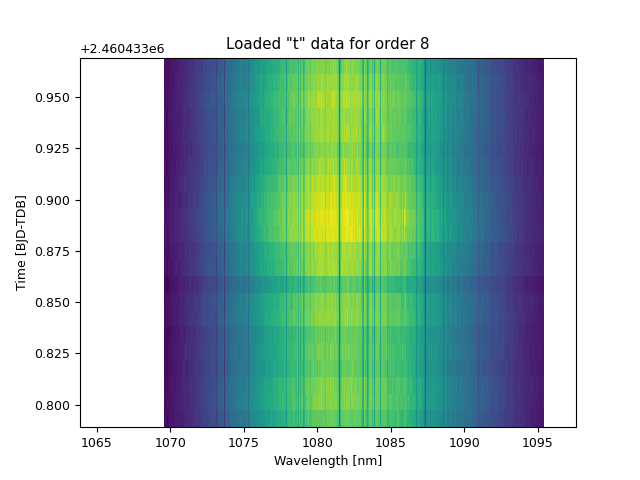

In [13]:
# Show data
order = 8
plt.figure()
plt.pcolormesh(t_wave[0,order], time_axis, t_data[:,order], shading='auto')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Time [BJD-TDB]')
plt.title('Loaded "t" data for order {}'.format(order))


**Set-up planet's and transit's parameters**

In [14]:
# Set the parameters required to simulate the planet's transit

###############################
# EVERYTHING IS IN SI UNITS ! #
###############################

# WASP-76 b like planet around Sun-like star: we reduced the stellar radius and increased the semi-major axis to reduce the transit duration down to something compatible with the observations
WASP76_params = {

    # stellar properties
    'Ms'            : 1.458 * const.M_sun.value,                                # Host star mass [kg] (Ehrenreich2020)
    'Rs'            : 1.4 * const.R_sun.value,                                  # Stellar radius (Arbitrary)
    'Ks'            : 116.02,                                                   # Host star RV amplitude [m/s] (Ehrenreich2020)
    'c'             : [0.1, 0.2],                                               # Limb darkening coefficients (EXOFAST)
    'Teff'          : 6329,                                                     # Effective Temperature (K) (Ehrenreich2020)
    'log(g)'        : 4.196,                                                    # Decimal logarithm of the surface gravity (cm/s**2) (Ehrenreich2020)
    'M/H'           : +0.366,                                                   # Metallicity index relative to the Sun (Ehrenreich2020)
    'vsini'         : 1.48e3,                                                   # stellar rotational velocity [m/s] (Ehrenreich2020)
    'Sys_Age'       : 1.816,                                                    # (Gyr) Age of the system (Ehrenreich2020)
    'distance'      : 194 * const.pc.value,                                     # system distance (m)

    # planet properties
    'Mp'            : 0.894 * const.M_jup.value,                                # Planet mass [kg] (Ehrenreich2020)
    'Rp'            : 1.854 * const.R_jup.value,                                # Planet radius (Ehrenreich2020)
    'Porb'          : 1.8098806,                                                # Planet orbital period [days] (Ehrenreich2020)
    'Teq'           : 2160,                                                     # Equilibrium (or Effective) Temperature (K) of the Planet (West2016)

    # transit ephemerides
    'midpoint'      : midpoint,                                                 # transit midpoint in BJD-TBD
    'time_vector'   : time_axis,                                                # absolute time (BJD-TDB)
    'time_from_mid' : time_axis - midpoint,                                     # time from mid transit in BJD-TBD
    'BERV'          : BERV,                                                     # BERV [m/s]

    # orbital properties
    'a'             : 0.05 * const.au.value,                                    # Semi Major axis (Arbitrary)
    'i'             : 89.623,                                                   # inclination (Ehrenreich2020)
    'e'             : 0,                                                        # excentricity (fixed)
    'w'             : 0,                                                        # STELLAR longitude of periapse (deg) (fixed)
    'lbda'          : 61.28,                                                    # spin-orbit angle (deg) (Ehrenreich2020)

    # system properties
    'Vs'            : -0.79e3,                                                  # GaiaDR3, [m/s] Vs < 0 means star is moving toward us. This Vsys contains the gravitational redshift & convective blueshift
}

# Add planet's theoretical Kp and logg in cgs for petitRADTRANS
WASP76_params['Kp'] =  WASP76_params['Ks'] * WASP76_params['Ms'] / WASP76_params['Mp']      # Planet RV amplitude [m/s] manually computed
WASP76_params['planet_logg_cgs'] = np.log10(const.G.cgs.value*(WASP76_params['Mp']*1e3/(WASP76_params['Rp']*100)**2)) # planet log gravity in cgs

# Overwrite the planet's Kp with an arbitrary value for injecting the signal at a specific position in the (Kp,V0) space
WASP76_params['Kp'] = 150e3 # m/s
WASP76_params['V0'] = 0e3  # m/s

# Set the default parameter used in the rest of the code
params = WASP76_params


# Compute petitRADTRANS model

In [27]:
# petitRADTRANS requires everything in cgs units, except for the wavelength range which is in microns. We convert SI from the params dictionary

spectral_model = SpectralModel(

    # Radtrans parameters
    pressures                      = np.logspace(-8, 2, 130),
    line_species                   = ['H2O', 'CO'],
    rayleigh_species               = ['H2', 'He'],
    gas_continuum_contributors     = ['H2-H2', 'H2-He'],
    line_opacity_mode              = 'lbl',
    line_by_line_opacity_sampling  = 1,

    # Planet parameters 
    planet_radius       = params['Rp'] * 1e2,  # cm
    reference_pressure  = 1e-2, # ref pressure at which planet's radius & logg are defined. This is pRT default value in documentation
    reference_gravity   = 10**params['planet_logg_cgs'], # surface gravity (not logg) cgs
    star_radius         = params['Rs'] * 1e2,  # cm
    
    # temperature profile (put a constant for an isothermal profile)
    temperature = 1200, # K

    # Mass fractions
    imposed_mass_fractions = {
        'H2O' : 10**-4, # MMR of H2O
        'CO'  : 10**-3, # MMR of CO
    },

    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12 -> Jupiter like ratio
        'H2': 37,
        'He': 12
    },

    # Spectral rebinning parameters
    wavelength_boundaries = [0.9,2.5] # microns

    # # Add clouds (optionnal)
    # opaque_cloud_top_pressure = 1e-4, # bar

    # ### Additional parameters for emission spectrum (optionnal) ###
    # scattering_in_emission=True,  # replace do_scat_emis from pRT2
    # is_observed=True,  # return the flux observed at system_distance
    # is_around_star=True,  # if True, calculate a PHOENIX stellar spectrum and add it to the emission spectrum
    # system_distance=params['distance'] * 1e2,  # m to cm, used to scale the spectrum
    # star_effective_temperature=params['Teff'],  # used to get the PHOENIX stellar spectrum model
    # orbit_semi_major_axis=params['a'] * 1e2,  # used to get the star flux irradiating the planet
    # # We can use a Guillot profile for temperature to introduce inversion and emission lines
    # temperature_profile_mode='guillot',
    # intrinsic_temperature=200,
    # guillot_temperature_profile_gamma=0.4,
    # guillot_temperature_profile_infrared_mean_opacity_solar_metallicity=0.01,
    # ################################################################

)


Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/amasson/data/petitRADTRANS/Lines/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO' from file '/home/amasson/data/petitRADTRANS/Lines/input_data/opacities/lines/line_by_line/CO/12C-16O/12C-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/amasson/data/petitRADTRANS/Lines/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/home/amasson/data/petitRADTRANS/Lines/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA o

Text(0, 0.5, 'Transit radius [Rjup]')

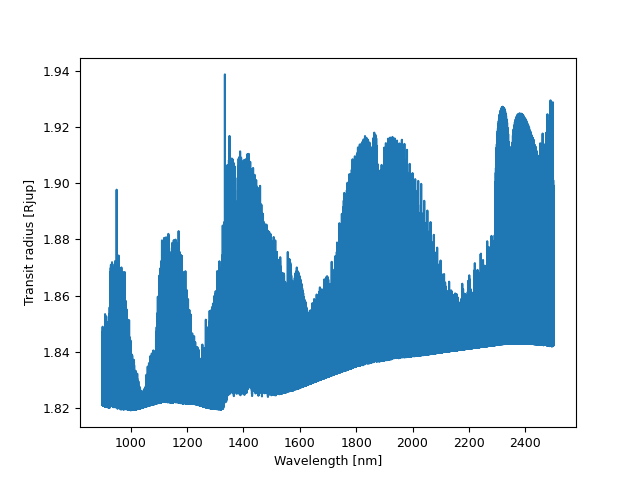

In [28]:
#####################
# Transmission mode #
#####################
# Compute and plot the petitRADTRANS model in transmission
wavelength_pRT, transit_radii = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True, # update the parameters with the new values (if any)
)

wave  = wavelength_pRT.flatten() * 1e7 # wavelength in nm 
model = transit_radii[0].flatten() / 1e2 # meters, the [0] are for removing useless axis

plt.figure()
plt.plot(wave,model/const.R_jup.value)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transit radius [Rjup]')

# #####################
# #   Emission mode   #
# #####################
# # Compute and plot the petitRADTRANS model in emission
# wavelength_pRT, transit_radii = spectral_model.calculate_spectrum(
#     mode='emission',
#     update_parameters=True, # update the parameters with the new values (if any)
# )

# wave  = wavelength_pRT.flatten() * 1e7 # wavelength in nm 
# model = transit_radii[:,0].flatten() #  the [0] are for removing useless axis

# plt.figure()
# plt.plot(wave,model)


# Build synthetic time series


Convolve to instrumental resolution and shift the petitRADTRANS model in the Earth rest frame for each observation to create the planet's synthetic time series.

**Convolve with instrumental function**

Compute Kepler orbit done
Delta RV during a single snapshot: 4.20e+03 m/s


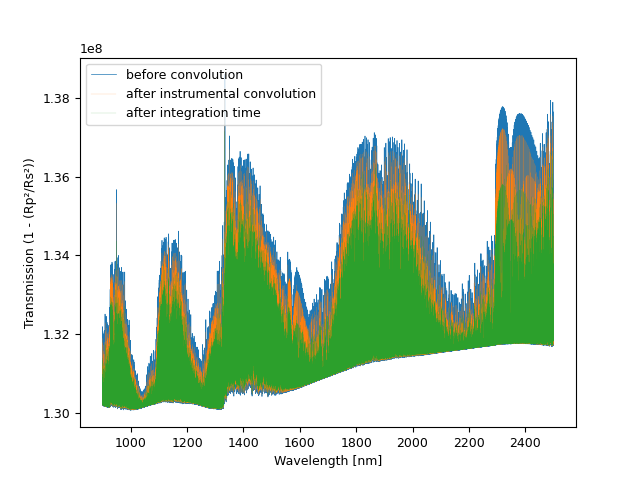

In [ ]:
# lower to SPIRou resolution:
model_convolved = lower_resolution(wave,model,pixel_size=1*2.28e3,nb_of_points=11)

# Add integration time broadening:
delta_RV = np.mean(np.diff(compute_Vp(params)))
print(f'Delta RV during a single snapshot: {delta_RV:.2e} m/s')
model_integrated = lower_resolution(wave, model_convolved, pixel_size=delta_RV, nb_of_points=11)

plt.figure()
plt.plot(wave,model,label='before convolution',lw=0.5)
plt.plot(wave,model_convolved,label='after instrumental convolution', lw=0.5)
plt.plot(wave,model_integrated,label='after integration time', lw=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission (1 - (Rp²/Rs²))')
plt.legend()


**Compute transit light curve wiht Batman**

Text(0, 0.5, 'Transit window weight')

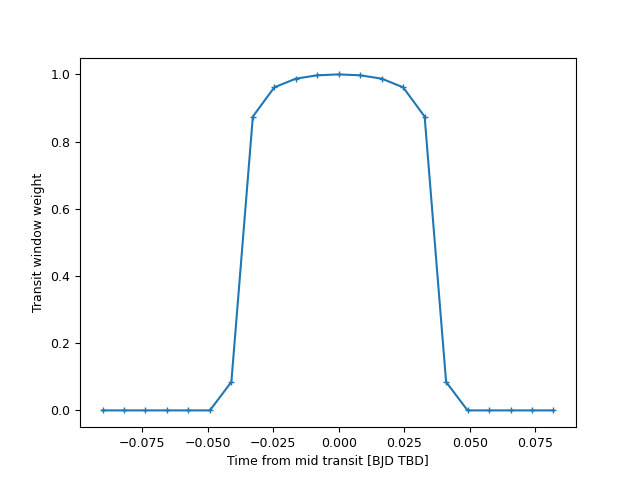

In [30]:
# Determine the limb dark laws based on the number of parameters
if len(params['c'])==4:
    limb_dark = 'nonlinear'                    
elif len(params['c'])==2:
    limb_dark = 'quadratic'
else:
    limb_dark = 'uniform'

# Batman's parameters
batman_params              = batman.TransitParams()     # object to store transit parameters
batman_params.t0           = 0.                         # time of inferior conjunction
batman_params.per          = params['Porb']             # orbital period
batman_params.rp           = params['Rp']/params['Rs']  # planet radius (in units of stellar radii)
batman_params.a            = params['a']/params['Rs']   # semi-major axis (in units of stellar radii)
batman_params.inc          = params['i']                # orbital inclination (in degrees)
batman_params.ecc          = params['e']                # eccentricity
batman_params.w            = params['w']                # longitude of periastron (in degrees)
batman_params.u            = params['c']                # limb darkening coefficients [u1, u2, u3, u4]
batman_params.limb_dark    = limb_dark                  # limb darkening model

# initializes model
batman_model = batman.TransitModel(batman_params, params['time_from_mid'])

# calculates light curve
light_curve = batman_model.light_curve(batman_params)

# transit window's weight
W = (1-light_curve)
W /= W.max()

# Divide the weight by the average kimb darkening (because max limb darkening reached at mid transit is higher than 1) :
if limb_dark == 'nonlinear':
    c1,c2,c3,c4 = c
    limb_avg = 1-c1-c2-c3-c4+0.8*c1+(2./3.)*c2+(4./7.)*c3+0.5*c4 # for non linear limb darkening only !
    W /= limb_avg

transit_weight = W

plt.figure()
plt.plot(params['time_from_mid'],transit_weight,ls='-',marker='+')
plt.xlabel('Time from mid transit [BJD TBD]')
plt.ylabel('Transit window weight')


**Shift time series in Earth RF**

Compute Kepler orbit done


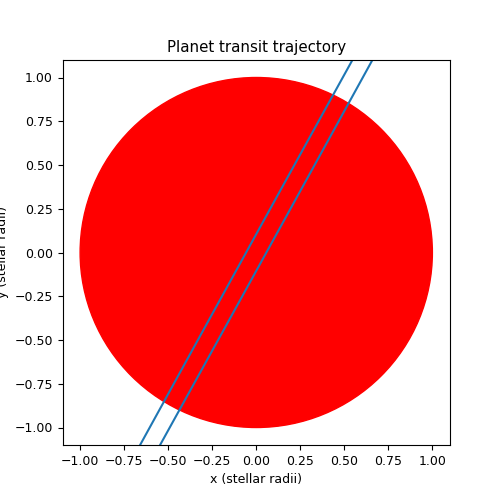

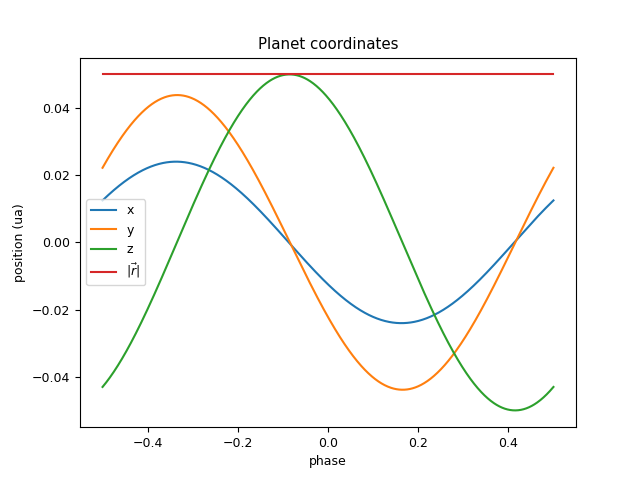

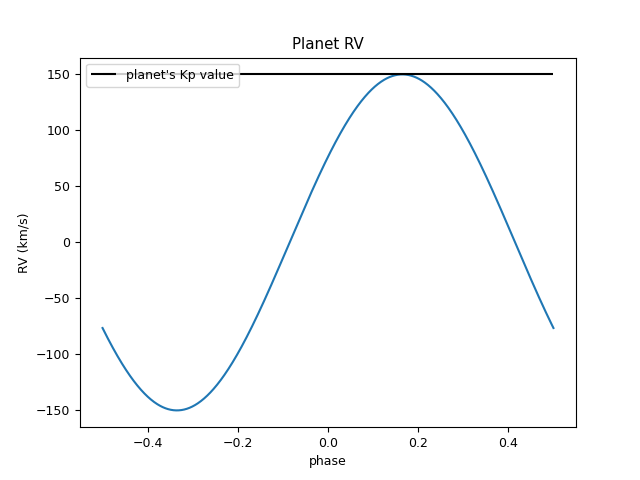

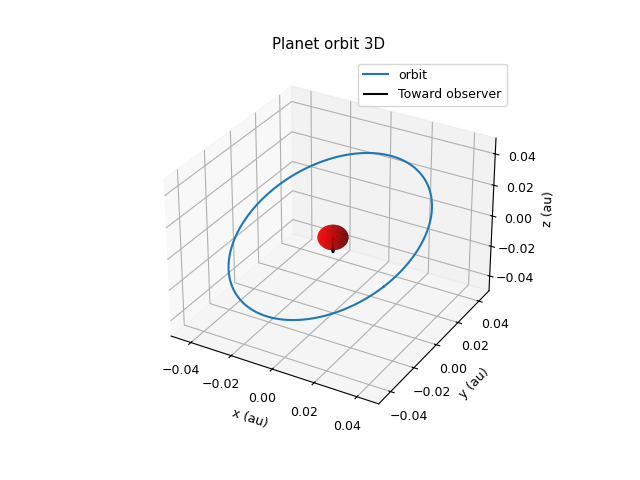

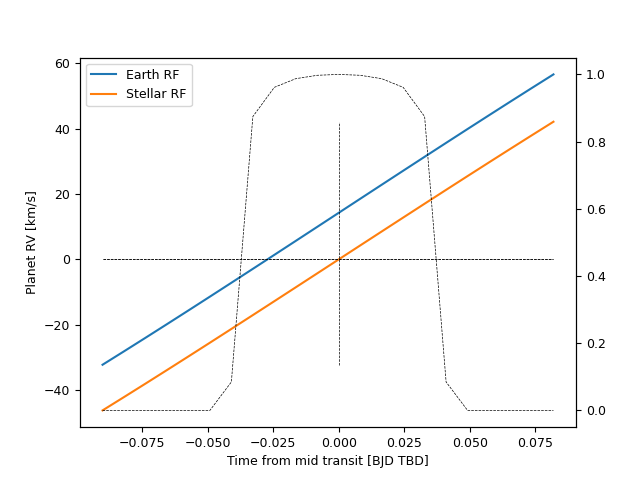

In [33]:
# compute planet's instant velocity and theoretical Kp in stellar RF taking into account eccentricity
Vp  = compute_Vp(params,show=True)

# compute the planet's RV in the Earth RF
Vd   = params['V0'] + Vp # planet's velocity along LOS in stellar RF
Vtot = Vd + params['Vs'] - params['BERV'] # in Earth RF

# With no eccentricity and V0 = 0 km/s, the planet's RV in the stellar RF is equal to 0 at midtransit
plt.figure()
plt.plot(params['time_from_mid'],Vtot/1e3,label='Earth RF')
plt.plot(params['time_from_mid'],Vd/1e3,label='Stellar RF')
# plt.plot(params["time_from_mid"],Vp/1e3,label='True Vp')
plt.xlabel('Time from mid transit [BJD TBD]')
plt.ylabel('Planet RV [km/s]')
plt.hlines(0,params['time_from_mid'].min(),params['time_from_mid'].max(),'k',ls='--',lw=0.5)
plt.hlines(params['V0']/1e3,params['time_from_mid'].min(),params['time_from_mid'].max(),'k',ls='--',lw=0.5)
plt.vlines(0,Vtot.min()/1e3,Vd.max()/1e3,'k',ls='--',lw=0.5)
plt.legend()
plt.twinx().plot(params['time_from_mid'],transit_weight,label='Transit window weight',ls='--',color='k',lw=0.5)


Text(0.5, 1.0, 'Synthetic time series of the planet')

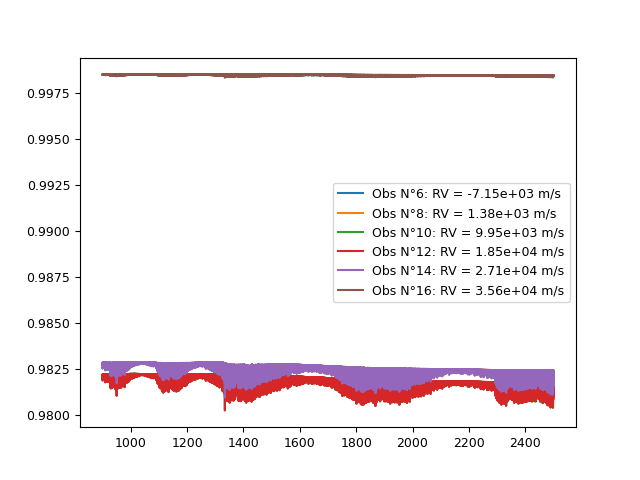

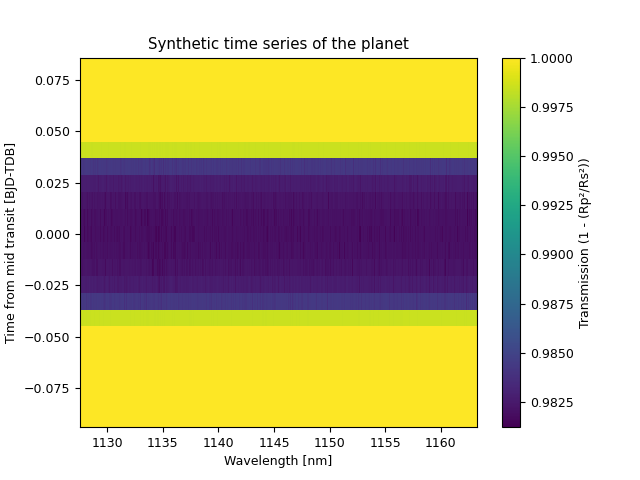

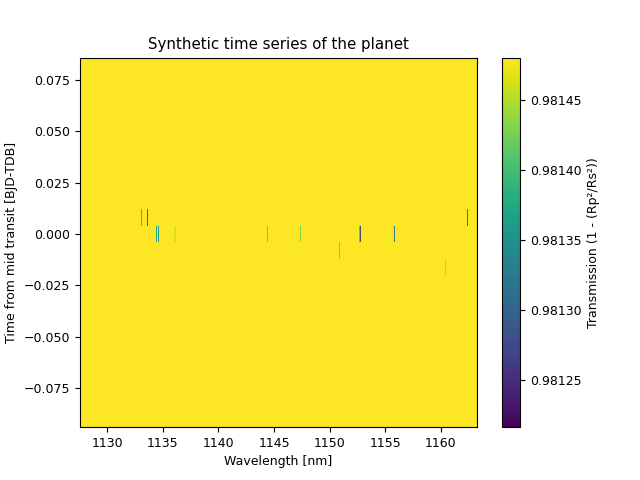

In [56]:
# shift the synthetic in Earth rest frame for each epoch and sample on data spectral bins
synthetic = np.ones_like(t_data) # will hold the synthetic time series
plt.figure()

for obs in np.where(transit_weight != 0)[0]:
    # shift
    wave_shifted = wave / (1 - (Vtot[obs] / const.c.value)) # V0 > 0 -> redshift, V0 < 0 -> blueshift
    synth_shifted = interp1d(wave_shifted,model_integrated,bounds_error=False)(wave) 
    # compute transmission spectrum
    transmission = 1 - transit_weight[obs]*(synth_shifted**2/params['Rs']**2) # model_integrated corresponds to the apparent planet radius at a given wavelength
    # plot some of them
    if (obs%2)==0: plt.plot(wave,transmission,label=f'Obs N°{obs}: RV = {Vtot[obs]:.2e} m/s')
    # sample on data spectral bins
    synthetic[obs] = interp1d(wave, transmission, bounds_error=False, fill_value=1.)(t_wave[obs])

plt.legend()

# plot the synthetic time series for a given order
order = 12
plt.figure()
plt.pcolormesh(t_wave[0,order], params['time_from_mid'], synthetic[:,order], shading='auto')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Time from mid transit [BJD-TDB]')
c = plt.colorbar()
c.set_label('Transmission (1 - (Rp²/Rs²))')
plt.title('Synthetic time series of the planet')

# plot the synthetic time series for a given order
order = 12
plt.figure()
plt.pcolormesh(t_wave[0,order], params['time_from_mid'], synthetic[:,order], shading='auto', vmax=(1-(params['Rp']**2/params['Rs']**2)))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Time from mid transit [BJD-TDB]')
c = plt.colorbar()
c.set_label('Transmission (1 - (Rp²/Rs²))')
plt.title('Synthetic time series of the planet')


# Inject in Data and save

We inject the synthetic planet signal by multiplying it to the raw data since this is the transmission signature of the planet.

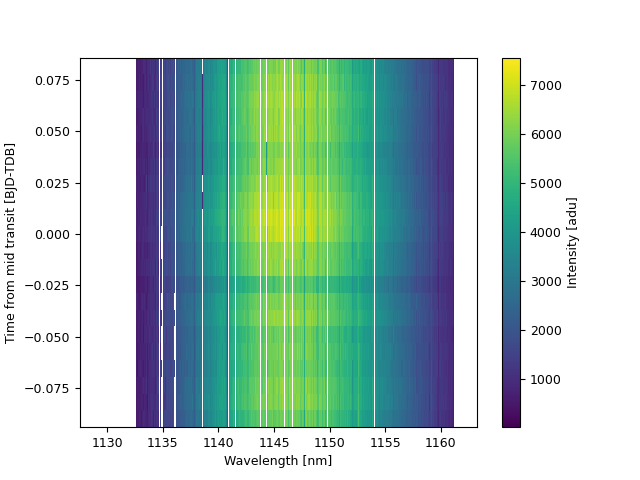

In [ ]:
# inject signal in data 
t_data_synthetic =  t_data * synthetic
e_data_synthetic =  e_data * synthetic

# plot after injection
plt.figure()
plt.pcolormesh(t_wave[0,order], params['time_from_mid'], t_data_synthetic[:,order], shading='auto')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Time from mid transit [BJD-TDB]')
c = plt.colorbar()
c.set_label('Intensity [adu]')


In [ ]:
# Save the synthetic data in fits files
save_dir = '/home/amasson/data/Kaperture_Science/Data/Synthetic Data/WASP-107/'
save_name = 'WASP76b_in_WASP107_H2O_CO_Kp_150_V0_0'

# create subfolder if it doesn't exist
if not os.path.exists(save_dir + save_name):
    os.makedirs(save_dir + save_name)

# copy the list of "t" & "e" fits file into the save_dir/save_name/ , then open them and replace the data with the synthetic one
for k,file in enumerate(t_fits_files):
    file_name = file.split('/')[-1]
    shutil.copy(file, save_dir + save_name + '/' + file_name)
    with fits.open(save_dir + save_name + '/' + file_name, mode='update') as hdul:
        hdul[1].data = t_data_synthetic[k]
        hdul.flush()
print('All t files saved!')

for k,file in enumerate(e_fits_files):
    file_name = file.split('/')[-1]
    shutil.copy(file, save_dir + save_name + '/' + file_name)
    with fits.open(save_dir + save_name + '/' + file_name, mode='update') as hdul:
        hdul[1].data = t_data_synthetic[k]
        hdul.flush()
print('All e files saved!')


All t files saved!
All e files saved!


In [59]:
# Save the planet's and model's parameters to store the true solution
true_model = {
    "Transit params": params,
    "petitRADTRANS params": spectral_model.model_parameters
}

# Save the dictionary to a file
with open(save_dir+save_name+'/true_model.pkl', 'wb') as file:
    pickle.dump(true_model, file)

print('True model parameters have been saved to {}'.format(save_dir + save_name + '/true_model.pkl'))


True model parameters have been saved to /home/amasson/data/Kaperture_Science/Data/Synthetic Data/WASP-107/WASP76b_in_WASP107_H2O_CO_Kp_150_V0_0_oversampleTest/true_model.pkl


In [60]:
# # Optional: save the original data (without synthetic) in a new folder
# save_name = 'Gl15A_original_no_injection'

# # create subfolder if doesn't exist
# if not save_name in os.listdir(save_dir):
#     os.mkdir(save_dir+save_name)

# for file in t_fits_files:
#     with fits.open(file, mode='update') as hdul:
#         # Save the modified FITS file with a new name
#         hdul.writeto(save_dir+save_name+'/'+save_name+'_'+os.path.basename(file), overwrite=True)
# print('All original t files (without injected synthetic data) have been saved to {}'.format(save_dir+save_name))
        
# for file in e_fits_files:
#     with fits.open(file, mode='update') as hdul:
#         # Save the modified FITS file with a new name
#         hdul.writeto(save_dir+save_name+'/'+save_name+'_'+os.path.basename(file), overwrite=True)
# print('All original t files (without injected synthetic data) have been saved to {}'.format(save_dir+save_name))


In [61]:
# Optional: open the dictionary containing the true parameters with pickle
import pprint
pp = pprint.PrettyPrinter(depth=4)

with open(save_dir+save_name+'/true_model.pkl','rb') as f:
    true_params = pickle.load(f)
    print('Transit parameters (SI units):\n')
    pp.pprint(true_params['Transit params']) # the transit, stellar, and planetary parameters
    print('\npetitRADTRANS parameters (cgs units):\n')
    pp.pprint(true_params['petitRADTRANS params']) # the parameters passed to petitRADTRANS to generate the atmospheric signature


Transit parameters (SI units):

{'BERV': array([-14749.80427522, -14774.53134127, -14799.57963476, -14824.88759058,
       -14850.4002894 , -14876.05669849, -14901.79786982, -14927.56967429,
       -14953.3119122 , -14978.9494477 , -15004.44003469, -15029.72541793,
       -15054.74449165, -15079.44057461, -15103.74720007, -15127.62188498,
       -15151.00822583, -15173.85043464, -15196.09712717, -15217.70006831,
       -15238.60877913, -15258.78026125]),
 'Kp': 150000.0,
 'Ks': 116.02,
 'M/H': 0.366,
 'Mp': 1.6969233900184293e+27,
 'Ms': 2.8991015914777584e+30,
 'Porb': 1.8098806,
 'Rp': 132546168.0,
 'Rs': 973979999.9999999,
 'Sys_Age': 1.816,
 'Teff': 6329,
 'Teq': 2160,
 'V0': 0.0,
 'Vs': -790.0,
 'a': 7479893535.0,
 'c': [0.1, 0.2],
 'distance': 5.986214508093253e+18,
 'e': 0,
 'i': 89.623,
 'lbda': 61.28,
 'log(g)': 4.196,
 'midpoint': 2460433.883186164,
 'planet_logg_cgs': 2.8093336065831234,
 'time_from_mid': array([-0.09010962, -0.08191843, -0.07372633, -0.06553474, -0.05734264

# Save the pRT model

In [62]:
# first column: wavelength, second column: transmission
np.savetxt(save_dir+save_name+'/petitradtrans_model.txt',np.array([wave,model]).T,header='Wavelength [nm]\tTransmission (1-(Rp/Rs)²)')
